### PHROGs, VFDB and CARDS database MMseqs2 similarity search results against the Pseudomonas infecting phages dataset. 

We want to find significant matches to significantly reduce the size of our dataset to run in the pipeline - ie functionnally annotate
- Comapre the alignemnt lenghts w query and target lenghts = if these lenghts are the same, then good match and we check if it is already annotated in the related database
- if we have a function, we then omit from our database and label as needed
- as seq id can be high but only on small lenght of the compared sequences, we need 'all'/majority of the sequence to be the same
- compare the alignment lenght
- if q lenght and t lenght are close, put row in a new tsv file, then check if alignment score ~= to the two lenghts, then look at seq id, bit score and evalue
- find thresholds to parse entire file

In [ ]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO

### PHROGS results

In [ ]:
# After running mmseqs search job, results.tsv obtained
# Adding headers to the tsv file
def add_headers_to_mmseqs_tsv(input_tsv, output_tsv):
    headers = [
       'query','target','alignmentScore', 'seqIdentity', 'eVal', 'queryStart', 'queryEnd', 'queryLen', 
        'targetStart', 'targetEnd', 'targetLen'
    ]
    df = pd.read_csv(input_tsv, sep='\t', header=None)
    df.columns = headers
    df.to_csv(output_tsv, sep='\t', index=False)
input_tsv = 'results.tsv'  
output_tsv = 'phrogs_mmseqs.tsv'  
add_headers_to_mmseqs_tsv(input_tsv, output_tsv)

- phrogs has 96,815 matches to compare
- sensitivity set to 70% as per phrogs documentation

In [ ]:
# Distribution of evalues 
data = pd.read_csv('phrogs_mmseqs.tsv', sep='\t')

plt.figure(figsize=(10, 6))
plt.hist(data['eVal'], bins=50, log=True)
plt.title('Distribution of e-Values')
plt.xlabel('e-Value')
plt.ylabel('Frequency (log scale)')
plt.grid(True)
plt.show()

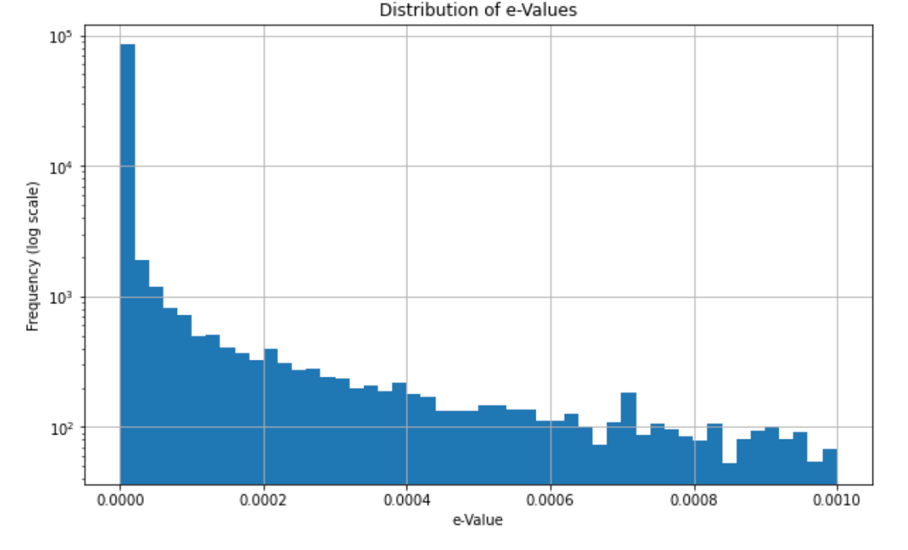

In [ ]:
# filter out based on evalue
data['query_aligned_length'] = data['queryEnd'] - data['queryStart']
data['target_aligned_length'] = data['targetEnd'] - data['targetStart']

length_similarity_threshold = 0.1  # 10% similarity
evalue_threshold = 1e-6

similar_alignment_length_filter = (
    abs(data['query_aligned_length'] - data['target_aligned_length']) /
    data['query_aligned_length'] <= length_similarity_threshold
)

evalue_filter = (data['eVal'] <= evalue_threshold)

significant_matches = data[
    similar_alignment_length_filter |
    evalue_filter]

significant_matches.to_csv('significant_matches_phrogs.tsv', sep='\t', index=False)


filtered from 96,815 down to 92,581

In [ ]:
# Adding the annotations 

data_phrogs = pd.read_csv('phrog_annot_v4.tsv', sep='\t')  
data_query = pd.read_csv('significant_matches_phrogs.tsv', sep='\t')  

data_query['phrog'] = data_query['query'].str.replace('phrog_', '').astype(int)

merged_data = pd.merge(data_query, data_phrogs, on='phrog', how='left')
merged_data = merged_data[['query', 'target','annot', 'category']]
merged_data.to_csv('annot_phrogs.tsv', sep='\t', index=False)

In [ ]:
# database with only known annotations, removing unknown annotations
data = pd.read_csv('annot_phrogs.tsv', sep='\t')
filtered_data = data[data['category'] != 'unknown function']
filtered_data.to_csv('known_annot_phrogs.tsv', sep='\t', index=False)

In [ ]:
#turn fasta file in a tsv with id and seq in two col
fasta_path = 'unique_multi_fasta.fasta'
ids = []
sequences = []

for record in SeqIO.parse(fasta_path, 'fasta'):
    ids.append(record.id)
    sequences.append(str(record.seq))

fasta_df = pd.DataFrame({
    'id': ids,
    'sequence': sequences
})

fasta_df.to_csv('unique_multi_fasta.tsv', sep='\t', index=False)

In [ ]:

fasta_tsv = pd.read_csv('unique_multi_fasta.tsv', sep='\t')
matches_tsv = pd.read_csv('known_annot_phrogs.tsv', sep='\t')
initial_count = fasta_tsv.shape[0]
filtered_fasta_tsv = fasta_tsv[~fasta_tsv['id'].isin(matches_tsv['target'])]
rows_removed = initial_count - filtered_fasta_tsv.shape[0]
filtered_fasta_tsv.to_csv('multifasta_filtered_phrogs.tsv', sep='\t', index=False)

- Total rows removed: 28415
- Remaining rows in the first TSV after filtering: 117935

### VFDB results

In [ ]:
#  Repeating steps, after running mmseqs search job, results.tsv obtained
# Adding headers to the tsv file
input_tsv = 'results.tsv'  
output_tsv = 'vfdb_mmseqs.tsv'  
add_headers_to_mmseqs_tsv(input_tsv, output_tsv)

VFDB has 5,506 matches to compare

In [ ]:
data = pd.read_csv('vfdb_mmseqs.tsv', sep='\t')

data['query_aligned_length'] = data['queryEnd'] - data['queryStart']
data['target_aligned_length'] = data['targetEnd'] - data['targetStart']

length_similarity_threshold = 0.1  # 10% similarity
evalue_threshold = 1e-6
similar_alignment_length_filter = (
    abs(data['query_aligned_length'] - data['target_aligned_length']) /
    data['query_aligned_length'] <= length_similarity_threshold
)

very_small_evalue_filter = (data['eVal'] <= evalue_threshold)

significant_matches = data[
    similar_alignment_length_filter |
    very_small_evalue_filter]

significant_matches.to_csv('significant_matches_vfdb_mmseqs.tsv', sep='\t', index=False)

Finding ind the annotation in the vfdb database, then match and only keep the truly 'unknown' annotated proteins. Duplicates also checked.

In [ ]:
matches_df = pd.read_csv('significant_matches_vfdb_mmseqs.tsv', sep='\t', usecols=['query', 'target'])

# Parse FASTA file to get annotations
annotations = {}
for record in SeqIO.parse('VFDB_setA_pro.fas', 'fasta'):
    identifier = record.id
    description = record.description
    annotations[identifier] = description

# Map annotations to matches based on query 
matches_df['annot'] = matches_df['query'].map(annotations)
matches_df.to_csv('annotated_matches_vfdb.tsv', sep='\t', index=False)

In [ ]:
# Need to remove in the fasta file the 5150 sequences
# There are matches with the phrogs db 
fasta_tsv = pd.read_csv('multifasta_filtered_phrogs2.tsv', sep='\t')
matches_tsv = pd.read_csv('annotated_matches_vfdb.tsv', sep='\t')

initial_count = fasta_tsv.shape[0]
filtered_fasta_tsv = fasta_tsv[~fasta_tsv['id'].isin(matches_tsv['target'])]

rows_removed = initial_count - filtered_fasta_tsv.shape[0]

filtered_fasta_tsv.to_csv('multifasta_filtered_phrogs_vfdb.tsv', sep='\t', index=False)

print(f"Total rows removed: {rows_removed}")
print(f"Remaining rows in the first TSV after filtering: {filtered_fasta_tsv.shape[0]}")

- Total rows removed: 474

### CARDS results

In [ ]:
# rerunning first steps again 
input_tsv = 'results.tsv'  
output_tsv = 'card_mmseqs.tsv'  
add_headers_to_mmseqs_tsv(input_tsv, output_tsv)

In [ ]:
data = pd.read_csv('card_mmseqs.tsv', sep='\t')
data['query_aligned_length'] = data['queryEnd'] - data['queryStart']
data['target_aligned_length'] = data['targetEnd'] - data['targetStart']

length_similarity_threshold = 0.1  # 10% similarity
evalue_threshold = 1e-6

similar_alignment_length_filter = (
    abs(data['query_aligned_length'] - data['target_aligned_length']) /
    data['query_aligned_length'] <= length_similarity_threshold
)

very_small_evalue_filter = (data['eVal'] <= evalue_threshold)
significant_matches = data[
    similar_alignment_length_filter |
    very_small_evalue_filter]
significant_matches.to_csv('significant_matches_cards.tsv', sep='\t', index=False)

In [ ]:
# Find annotations with ARO categories data
aro_data = pd.read_csv('aro_categories_index.tsv', sep='\t', usecols=['Protein Accession', 'Drug Class', 'Resistance Mechanism'])
matches = pd.read_csv('significant_matches_cards.tsv', sep='\t', usecols=['query', 'target'])
merged_data = pd.merge(matches, aro_data, left_on='query', right_on='Protein Accession')
merged_data['annot'] = merged_data['Drug Class'] + "; " + merged_data['Resistance Mechanism']
final_data = merged_data[['query', 'target', 'annot']]
final_data.to_csv('annotated_cards.tsv', sep='\t', index=False)

In [6]:
# remove final matches
fasta_tsv = pd.read_csv('multifasta_filtered_phrogs_vfdb.tsv', sep='\t')
matches_tsv = pd.read_csv('cards_filtered_output.tsv', sep='\t')

initial_count = fasta_tsv.shape[0]
filtered_fasta_tsv = fasta_tsv[~fasta_tsv['id'].isin(matches_tsv['target'])]

rows_removed = initial_count - filtered_fasta_tsv.shape[0]

filtered_fasta_tsv.to_csv('multifasta_filtered_phrogs_vfdb_cards.tsv', sep='\t', index=False)

print(f"Total rows removed: {rows_removed}")
print(f"Remaining rows in the first TSV after filtering: {filtered_fasta_tsv.shape[0]}")

Total rows removed: 27
Remaining rows in the first TSV after filtering: 117434


### final db size  117,434
now we have our mulitfasta file wiht truly unknown annotated functions. we can now rerun clustering